C:\Users\shami\AppData\Local\Temp\ipykernel_54732\4061452903.py:58: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N_base, calc_second_order=False)


Running simulations: 100%|██████████| 896/896 [00:31<00:00, 28.46it/s]



=== SOBOL SENSITIVITY RESULTS ===
  beta : S1 = 0.582   ST = 0.605
 gamma : S1 = 0.255   ST = 0.250
    mu : S1 = 0.134   ST = 0.139
   lam : S1 = 0.011   ST = 0.007
     T : S1 = -0.005   ST = 0.001

=== PRCC RESULTS ===
  beta : PRCC = 0.891
 gamma : PRCC = -0.556
    mu : PRCC = -0.346
   lam : PRCC = 0.224
     T : PRCC = 0.360


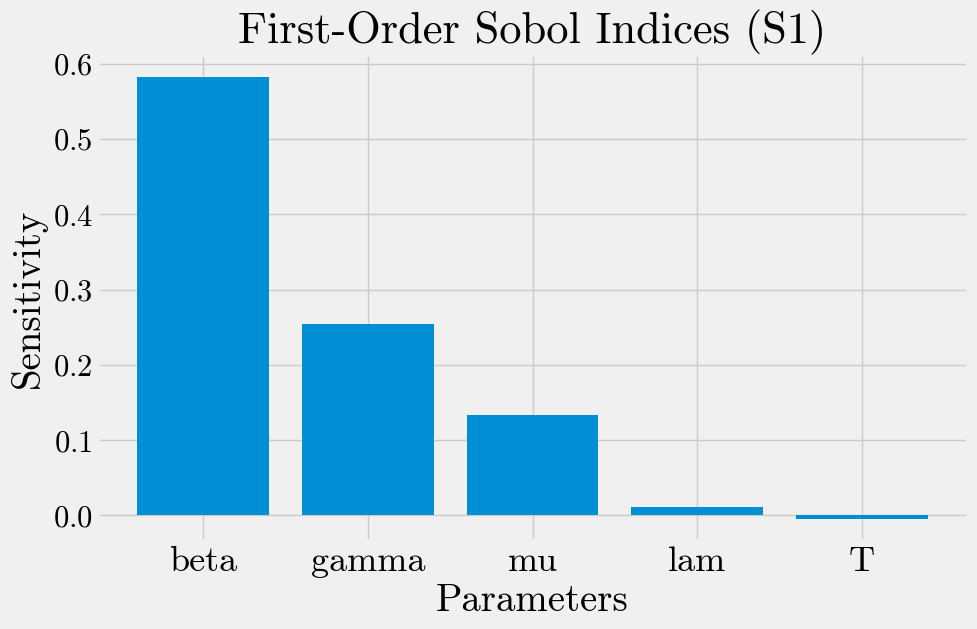

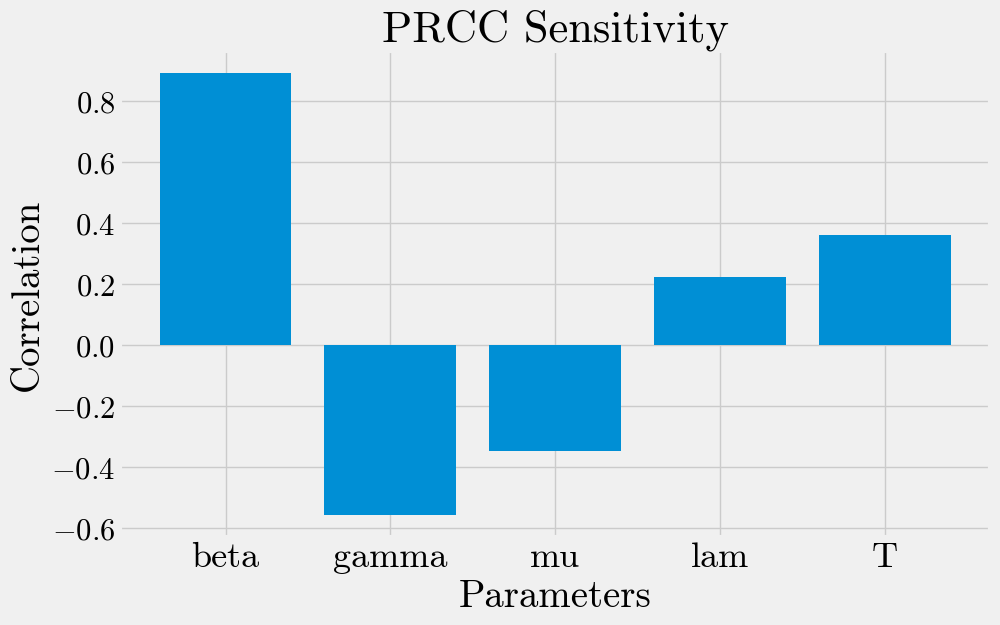

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.stats import rankdata, spearmanr
from tqdm import tqdm

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['axes.formatter.use_mathtext'] = True 

# ============================================================
# 1. MODEL: Dynamic alpha(t) + addiction SIS tobacco model
# ============================================================

def alpha_t(t, T, lam):
    """Time-dependent pro/anti-tobacco factor a(t)."""
    osc = (1 - np.cos(2 * np.pi * t / T)) / 2
    return 0.7 + 0.3 * np.exp(-lam * t) * osc

def rhs_tobacco(t, y, p):
    S, D = y
    beta, gamma, mu, N, T, lam = (
        p["beta"], p["gamma"], p["mu"], p["N"], p["T"], p["lam"]
    )
    a = alpha_t(t, T, lam)
    dSdt = mu * N - a * beta * S * D / N + gamma * D - mu * S
    dDdt = a * beta * S * D / N - gamma * D - mu * D
    return [dSdt, dDdt]

def simulate(params, t_final=60):
    y0 = [0.4, 0.6]
    sol = solve_ivp(lambda t,y: rhs_tobacco(t,y,params),
                    [0, t_final], y0, max_step=0.1)
    D_end = sol.y[1, -1]
    return D_end / params["N"]

# ============================================================
# 2. GLOBAL SENSITIVITY ANALYSIS — SOBOL (Saltelli)
# ============================================================

problem = {
    "num_vars": 5,
    "names": ["beta", "gamma", "mu", "lam", "T"],
    "bounds": [
        [0.3, 1.0],      # beta
        [0.05, 0.25],    # gamma
        [0.05, 0.2],     # mu
        [0.005, 0.08],   # lambda
        [6.0, 24.0]      # T in months
    ]
}

# Sample using Saltelli
N_base = 128
param_values = saltelli.sample(problem, N_base, calc_second_order=False)

# Run model with progress bar
Y = []
for p in tqdm(param_values, desc="Running simulations"):
    params = {
        "beta": p[0], "gamma": p[1], "mu": p[2], "lam": p[3], 
        "T": p[4], "N": 1.0
    }
    Y.append(simulate(params))
Y = np.array(Y)

# Compute Sobol indices
Si = sobol.analyze(problem, Y, calc_second_order=False)

print("\n=== SOBOL SENSITIVITY RESULTS ===")
for name, s1, st in zip(problem["names"], Si["S1"], Si["ST"]):
    print(f"{name:>6s} : S1 = {s1:.3f}   ST = {st:.3f}")

# ============================================================
# 3. PRCC
# ============================================================

def compute_prcc(X, Y):
    R = np.array([rankdata(X[:,i]) for i in range(X.shape[1])]).T
    Ry = rankdata(Y)
    prcc_vals = []
    for j in range(R.shape[1]):
        others = np.delete(R, j, axis=1)
        beta_x = np.linalg.lstsq(others, R[:, j], rcond=None)[0]
        beta_y = np.linalg.lstsq(others, Ry, rcond=None)[0]
        rx = R[:, j] - others @ beta_x
        ry = Ry - others @ beta_y
        prcc_vals.append(spearmanr(rx, ry)[0])
    return prcc_vals

X = param_values
prcc_vals = compute_prcc(X, Y)

print("\n=== PRCC RESULTS ===")
for name, pr in zip(problem["names"], prcc_vals):
    print(f"{name:>6s} : PRCC = {pr:.3f}")

# ============================================================
# 4. OPTIONAL: Plot
# ============================================================


plt.figure(figsize=(10, 6))
plt.style.use('fivethirtyeight')
plt.bar(problem["names"], Si["S1"])
plt.title('First-Order Sobol Indices (S1)', fontsize=32)
plt.ylabel('Sensitivity', fontsize=28)
plt.xlabel('Parameters', fontsize=28)
plt.xticks(fontsize=26)
plt.yticks(fontsize=22)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.style.use('fivethirtyeight')
plt.bar(problem["names"], prcc_vals)
plt.title("PRCC Sensitivity", fontsize=32)
plt.ylabel("Correlation", fontsize=28)
plt.xlabel('Parameters', fontsize=28)
plt.xticks(fontsize=26)
plt.yticks(fontsize=22)
plt.grid(True)
plt.show()


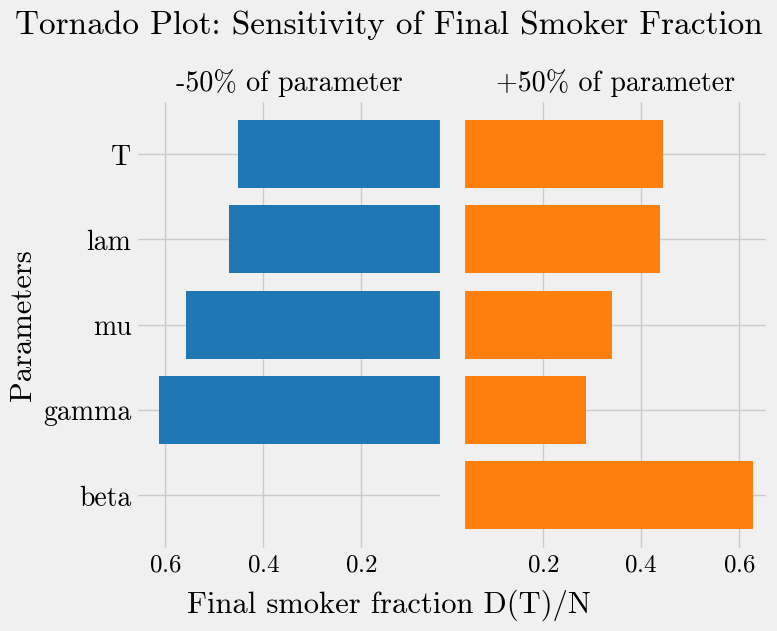

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# RHS of ODEs
# ------------------------------------------------------------
def rhs_tobacco(t, y, p):
    S, D = y
    beta, gamma, mu, N, T, lam = (
        p["beta"], p["gamma"], p["mu"], p["N"], p["T"], p["lam"]
    )
    a = 0.7 + 0.3 * np.exp(-lam * t) * (1 - np.cos(2 * np.pi * t / T)) / 2
    dSdt = mu * N - a * beta * S * D / N + gamma * D - mu * S
    dDdt = a * beta * S * D / N - gamma * D - mu * D
    return [dSdt, dDdt]

# ------------------------------------------------------------
# Tornado simulation
# ------------------------------------------------------------
def tornado_sim(params, t_final=60):
    y0 = [0.4, 0.6]
    sol = solve_ivp(lambda t,y: rhs_tobacco(t,y,params),
                    [0, t_final], y0, max_step=0.1)
    return sol.y[1,-1] / params["N"]

# ------------------------------------------------------------
# Base parameter set
# ------------------------------------------------------------
base_params = {
    "beta": 0.625,
    "gamma": 0.15,
    "mu": 0.10,
    "lam": 0.03,
    "T": 12.0,
    "N": 1.0
}

param_names = ["beta", "gamma", "mu", "lam", "T"]

# ------------------------------------------------------------
# Run low/high ±50% simulations
# ------------------------------------------------------------
QoI_min = []
QoI_max = []

for p in param_names:
    p_low  = base_params.copy()
    p_high = base_params.copy()

    p_low[p]  *= 0.5
    p_high[p] *= 1.5

    QoI_min.append(tornado_sim(p_low))
    QoI_max.append(tornado_sim(p_high))

QoI_min = np.array(QoI_min)
QoI_max = np.array(QoI_max)

# ------------------------------------------------------------
# Tornado plot in "two-panel" style
# ------------------------------------------------------------
pos = np.arange(len(param_names)) + 0.5

fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=(8,6), 
                                        sharey=True)

fig.suptitle("Tornado Plot: Sensitivity of Final Smoker Fraction", 
             fontsize=24)

# Left: Low values
ax_left.barh(pos, QoI_min, align='center', color='tab:blue')
ax_left.invert_xaxis()
ax_left.set_xlim(max(QoI_max)*1.05, min(QoI_min)*0.95)
ax_left.set_ylabel('Parameters', fontsize=22)
ax_left.set_yticks([])

# Right: High values
ax_right.barh(pos, QoI_max, align='center', color='tab:orange')
ax_right.set_yticks(pos)
ax_right.set_yticklabels(param_names, ha='center')
ax_right.set_xlim(min(QoI_min)*0.95, max(QoI_max)*1.05)

# Titles
ax_left.set_title("-50% of parameter")
ax_right.set_title("+50% of parameter")
ax_left.tick_params(axis='x', labelsize=18)
ax_right.tick_params(axis='x', labelsize=18)
ax_left.tick_params(axis='y', labelsize=20)

# Shared x-label
fig.text(0.5, -0.025, "Final smoker fraction D(T)/N", ha='center', size=22)

plt.tight_layout()
plt.show()


In [62]:
print(param_names)
print(QoI_min)
print(QoI_max)


['beta', 'gamma', 'mu', 'lam', 'T']
[0.03759114 0.61247029 0.55777086 0.47063184 0.45064878]
[0.62795185 0.2880572  0.34127376 0.43821114 0.44572955]


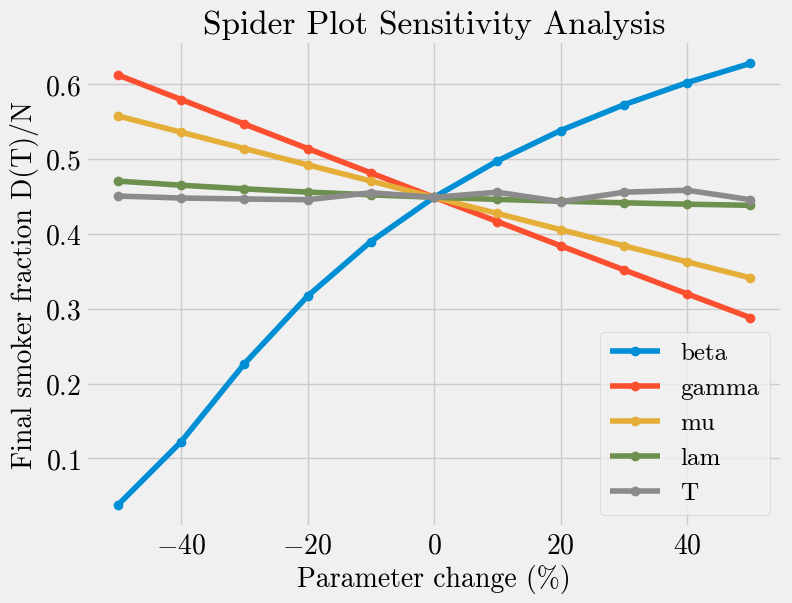

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ------------------------------------------------------------
# Spider plot for tobacco SIS model
# ------------------------------------------------------------
def rhs_tobacco(t, y, p):
    S, D = y
    beta, gamma, mu, N, T, lam = (
        p["beta"], p["gamma"], p["mu"], p["N"], p["T"], p["lam"]
    )
    a = 0.7 + 0.3 * np.exp(-lam * t) * (1 - np.cos(2 * np.pi * t / T)) / 2
    dSdt = mu * N - a * beta * S * D / N + gamma * D - mu * S
    dDdt = a * beta * S * D / N - gamma * D - mu * D
    return [dSdt, dDdt]

def run_model_fraction(params):
    """Return final fraction D(T)/N."""
    y0 = [0.4, 0.6]
    sol = solve_ivp(lambda t,y: rhs_tobacco(t,y,params),
                    [0, 60], y0, max_step=0.1)
    return sol.y[1,-1] / params["N"]

# Base parameters
base_params = {
    "beta": 0.625,
    "gamma": 0.15,
    "mu": 0.10,
    "lam": 0.03,
    "T": 12.0,
    "N": 1.0
}

param_names = ["beta", "gamma", "mu", "lam", "T"]
num_steps = 11
percent_changes = np.linspace(-0.5, 0.5, num_steps)  # -50% → +50%

plt.figure(figsize=(8,6))

for pname in param_names:
    outputs = []
    for pct in percent_changes:
        params = base_params.copy()
        params[pname] = base_params[pname] * (1 + pct)
        outputs.append(run_model_fraction(params))
    plt.plot(percent_changes * 100, outputs, marker='o', label=pname)

plt.style.use('fivethirtyeight')
plt.xlabel("Parameter change (%)", fontsize=20)
plt.ylabel("Final smoker fraction D(T)/N", fontsize=20)
plt.title("Spider Plot Sensitivity Analysis", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()


In [64]:
print(param_names)
param_names = ["beta", "gamma", "mu", "lam", "T"]
num_steps = 11
percent_changes = np.linspace(-0.5, 0.5, num_steps)  # -50% → +50%

for pname in param_names:
    outputs = []
    for pct in percent_changes:
        params = base_params.copy()
        params[pname] = base_params[pname] * (1 + pct)
        outputs.append(run_model_fraction(params))
    print(outputs)

['beta', 'gamma', 'mu', 'lam', 'T']
[np.float64(0.03759114294122365), np.float64(0.12220945241338806), np.float64(0.22639983376971742), np.float64(0.316844338844947), np.float64(0.38986458029374016), np.float64(0.4489858969258692), np.float64(0.49759761609596626), np.float64(0.5382174265566273), np.float64(0.5726613125256619), np.float64(0.6022484709289473), np.float64(0.6279518486461402)]
[np.float64(0.6124702900361482), np.float64(0.5796279160803295), np.float64(0.5468540565894107), np.float64(0.5141522647901104), np.float64(0.4815273288681413), np.float64(0.4489858969258692), np.float64(0.41653739432413994), np.float64(0.3841953848223869), np.float64(0.351979618020501), np.float64(0.3199191550136921), np.float64(0.28805720346184094)]
[np.float64(0.5577708649741384), np.float64(0.5359452457656381), np.float64(0.5141522647901104), np.float64(0.4923934044056952), np.float64(0.4706705091511891), np.float64(0.4489858969258692), np.float64(0.4273425030975243), np.float64(0.405744068316111

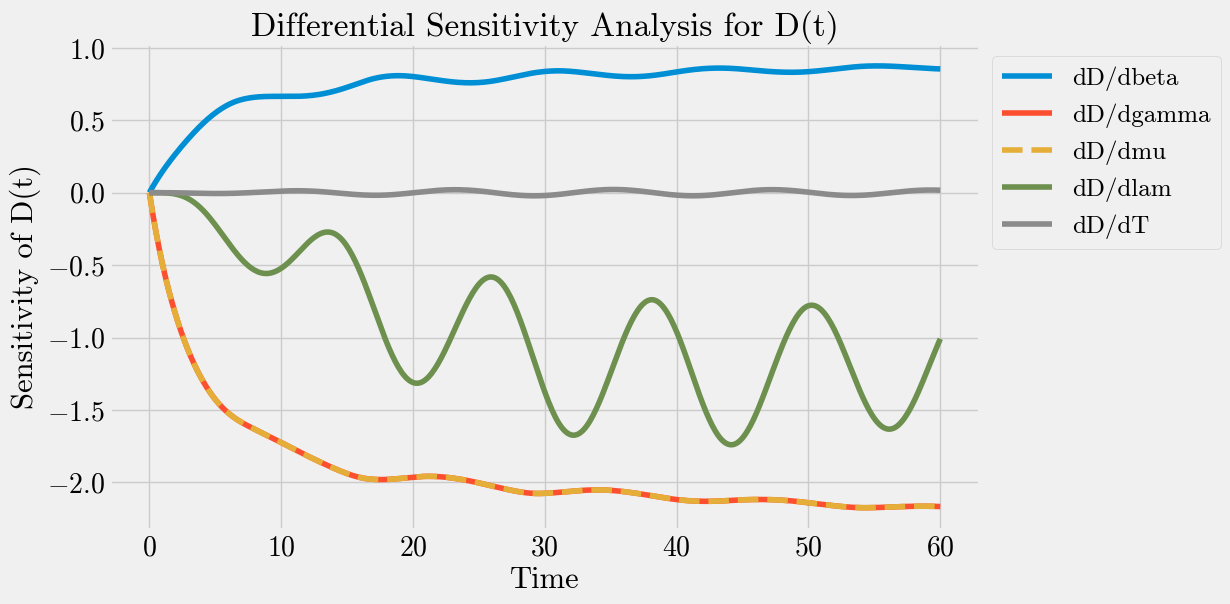

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Time-dependent alpha
# ------------------------------------------------------------
def alpha_t(t, T, lam):
    osc = (1 - np.cos(2 * np.pi * t / T)) / 2
    return 0.7 + 0.3 * np.exp(-lam * t) * osc

# ------------------------------------------------------------
# Base tobacco SIS model
# ------------------------------------------------------------
def rhs_tobacco(t, y, p):
    S, D = y
    beta, gamma, mu, N, T, lam = (
        p["beta"], p["gamma"], p["mu"], p["N"], p["T"], p["lam"]
    )
    a = alpha_t(t, T, lam)
    dSdt = mu*N - a*beta*S*D/N + gamma*D - mu*S
    dDdt = a*beta*S*D/N - gamma*D - mu*D
    return [dSdt, dDdt]

# ------------------------------------------------------------
# Differential sensitivity
# ------------------------------------------------------------
def rhs_diff_sensitivity(t, Y, p, p_name):
    """
    Augmented system: [S, D, dS/dp, dD/dp]
    """
    S, D, Sp, Dp = Y
    beta, gamma, mu, N, T, lam = (
        p["beta"], p["gamma"], p["mu"], p["N"], p["T"], p["lam"]
    )

    a = alpha_t(t, T, lam)
    f = mu*N - a*beta*S*D/N + gamma*D - mu*S
    g = a*beta*S*D/N - gamma*D - mu*D

    # Jacobian
    df_dS = -a*beta*D/N - mu
    df_dD = -a*beta*S/N + gamma
    dg_dS = a*beta*D/N
    dg_dD = a*beta*S/N - gamma - mu

    # Numerical partial derivative wrt parameter p_name
    dp = 1e-4
    p_plus = p.copy()
    p_minus = p.copy()
    p_plus[p_name] = p[p_name] + dp
    p_minus[p_name] = p[p_name] - dp

    f_p = (rhs_tobacco(t, [S, D], p_plus)[0] -
           rhs_tobacco(t, [S, D], p_minus)[0]) / (2*dp)
    g_p = (rhs_tobacco(t, [S, D], p_plus)[1] -
           rhs_tobacco(t, [S, D], p_minus)[1]) / (2*dp)

    dSpdt = f_p + df_dS*Sp + df_dD*Dp
    dDpdt = g_p + dg_dS*Sp + dg_dD*Dp

    return [f, g, dSpdt, dDpdt]

# ------------------------------------------------------------
# Base parameters and list of parameters
# ------------------------------------------------------------
base_params = {
    "beta": 0.625,
    "gamma": 0.15,
    "mu": 0.10,
    "lam": 0.03,
    "N": 1.0,
    "T": 12.0
}

param_names = ["beta", "gamma", "mu", "lam", "T"]

linestyles = {
    "beta": "-",
    "gamma": "-",
    "mu": "--",
    "lam": "-",
    "T": "-"
}

plt.figure(figsize=(10,6))
t_eval = np.linspace(0, 60, 500)

for pname in param_names:
    sol = solve_ivp(lambda t,y: rhs_diff_sensitivity(t, y, base_params, pname),
                    [0, 60], [0.4, 0.6, 0, 0], t_eval=t_eval)
    D_p = sol.y[3]
    plt.plot(sol.t, D_p, label=f"dD/d{pname}", linestyle=linestyles[pname])

plt.style.use('fivethirtyeight')
plt.xlabel("Time", fontsize=22)
plt.ylabel("Sensitivity of D(t)", fontsize=22)
plt.title("Differential Sensitivity Analysis for D(t)", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [65]:
t_eval = np.linspace(0, 60, 500)

for pname in param_names:
    sol = solve_ivp(lambda t,y: rhs_diff_sensitivity(t, y, base_params, pname),
                    [0, 60], [0.4, 0.6, 0, 0], t_eval=t_eval)
    D_p = sol.y[3]

    print(pname, D_p)

beta [0.         0.01984607 0.0390218  0.05758118 0.07557424 0.09304718
 0.11004279 0.12660147 0.14275713 0.15854095 0.17398198 0.18910715
 0.2039412  0.21850679 0.23282438 0.24691233 0.26078683 0.27446195
 0.2879496  0.30125957 0.31439949 0.32737484 0.34018899 0.35284315
 0.36533637 0.37766559 0.38982559 0.40180902 0.41360637 0.42520599
 0.43659338 0.44775787 0.45869122 0.46938548 0.47983299 0.49002642
 0.49995871 0.50962313 0.51901324 0.52812292 0.53694633 0.54547794
 0.55371253 0.56164518 0.56927128 0.57658651 0.58358687 0.59026863
 0.5966284  0.60266308 0.60836988 0.61374628 0.61879012 0.62349948
 0.6278728  0.63190879 0.63560646 0.63896738 0.64203847 0.64484873
 0.64741121 0.64973874 0.65184389 0.65373901 0.65543617 0.65694724
 0.65828382 0.65945727 0.66047871 0.66135903 0.66210884 0.66273856
 0.66325831 0.66367802 0.66400735 0.6642557  0.66443227 0.66454598
 0.66460553 0.66461936 0.66459568 0.66454245 0.6644674  0.66438278
 0.66430153 0.66423068 0.66417712 0.66414761 0.66414876 0